<a href="https://colab.research.google.com/github/garciafido/cima-goes/blob/master/cima_goes_usage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 - Install depencencies

In [1]:
!pip install -q netCDF4
!pip install -q  pyproj
!pip install -q aioftp
!pip install -q aiofiles
# Cartopy
!apt-get install libproj-dev proj-data proj-bin
!apt-get install libgeos-dev
!pip install -q  cython
!pip install -q  cartopy

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libproj-dev is already the newest version (4.9.3-2).
proj-bin is already the newest version (4.9.3-2).
proj-data is already the newest version (4.9.3-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 4 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgeos-dev is already the newest version (3.6.2-1build2).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 4 not upgraded.


# 2 - Install cima.goes library

In [2]:
!pip uninstall -y -q cima.goes
# !pip install --upgrade cima.goes
!pip install -q git+https://github.com/garciafido/cima-goes.git
!pip show cima.goes

Name: cima.goes
Version: 1.1b61
Summary: GOES-16 File Processing
Home-page: https://github.com/garciafido/cima-goes
Author: Fido Garcia
Author-email: garciafido@gmail.com
License: MIT
Location: /usr/local/lib/python3.6/dist-packages
Requires: 
Required-by: 


# 3- Example 1: Getting Blob information from GOES repository

In [3]:
import json
from cima.goes import Band, Product, ProductBand
from cima.goes.utils import timeit
from cima.goes.tiles import load_tiles, save_tiles, generate_tiles
from cima.goes.storage import storage_type, storage_info, goesdata_info
from cima.goes.storage import mount_goesdata, mount_store


CREDENTIALS_FILEPATH = '/OTs/gcs_credentials.json'
TILES_FILEPATH = '/OTs/ir_vis_tiles.json'
FTP_HOST = '<Your Server URL>'
FTP_USER = '<Your User Name>'
FTP_PASSWORD = '<Your Password>'


def get_gcs_credentials(file_store):
    ftp = mount_store(file_store)
    data = ftp.download_stream(CREDENTIALS_FILEPATH)
    return json.loads(data.decode('UTF-8'))


def get_goesdata():
    # Retrieve GCS credentials from FTP server
    ftp_info = storage_info(
        storage_type.FTP,
        host=FTP_HOST,
        user=FTP_USER,
        password=FTP_PASSWORD)
    credentials_as_dict = get_gcs_credentials(ftp_info)

    # Create GOES storage access
    goes_info = goesdata_info(storage_type.GCS,
                              credentials_as_dict=credentials_as_dict)
    return mount_goesdata(goes_info)


@timeit
def blobs_usage():
    goesdata = get_goesdata()

    band_IR = ProductBand(Product.CMIPF, Band.CLEAN_LONGWAVE_WINDOW)

    blobs_IR = goesdata.one_hour_blobs(2019, 60, 16, band_IR)
    print(f'Bands of {band_IR.band.name}')
    for blob in blobs_IR.blobs:
        print(blob.name)
    print('-' * 101)

    band_VIS = ProductBand(Product.RadF, Band.RED)

    grouped_blobs = goesdata.grouped_one_hour_blobs(2019, 76, 12, [band_VIS, band_IR])
    print(f'Grouped bands')
    for group in grouped_blobs:
        print(f'{group.start[7:9]}:{group.start[9:11]}')
        for band_blobs in group.blobs:
            print(f'    {band_blobs.band.name}', band_blobs.blobs[0].name)
    print('-' * 101)


blobs_usage()

Bands of CLEAN_LONGWAVE_WINDOW
ABI-L2-CMIPF/2019/060/16/OR_ABI-L2-CMIPF-M3C13_G16_s20190601600312_e20190601611091_c20190601611168.nc
ABI-L2-CMIPF/2019/060/16/OR_ABI-L2-CMIPF-M3C13_G16_s20190601615312_e20190601626091_c20190601626168.nc
ABI-L2-CMIPF/2019/060/16/OR_ABI-L2-CMIPF-M3C13_G16_s20190601630312_e20190601641091_c20190601641166.nc
ABI-L2-CMIPF/2019/060/16/OR_ABI-L2-CMIPF-M3C13_G16_s20190601645312_e20190601656091_c20190601656168.nc
-----------------------------------------------------------------------------------------------------
Grouped bands
12:00
    RED ABI-L1b-RadF/2019/076/12/OR_ABI-L1b-RadF-M3C02_G16_s20190761200368_e20190761211135_c20190761211172.nc
    CLEAN_LONGWAVE_WINDOW ABI-L2-CMIPF/2019/076/12/OR_ABI-L2-CMIPF-M3C13_G16_s20190761200368_e20190761211146_c20190761211226.nc
12:15
    RED ABI-L1b-RadF/2019/076/12/OR_ABI-L1b-RadF-M3C02_G16_s20190761215368_e20190761226135_c20190761226168.nc
    CLEAN_LONGWAVE_WINDOW ABI-L2-CMIPF/2019/076/12/OR_ABI-L2-CMIPF-M3C13_G16_s2019076

# 4 - Example 2: Generation and saving of new Tiles and their subsequent reload using FTP protocol

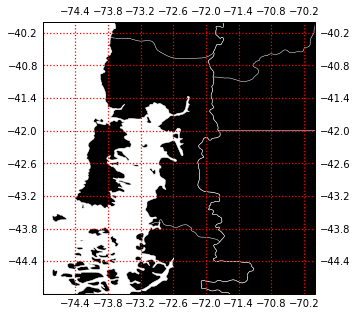

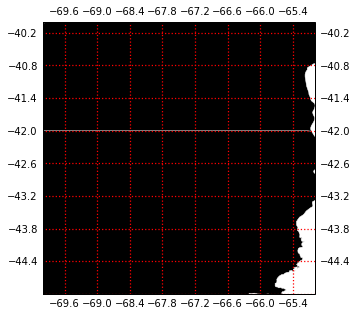

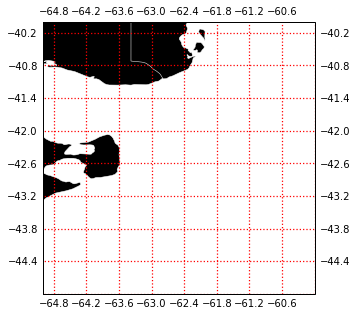

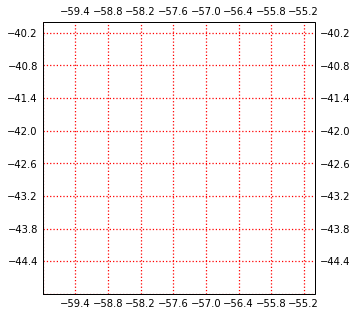

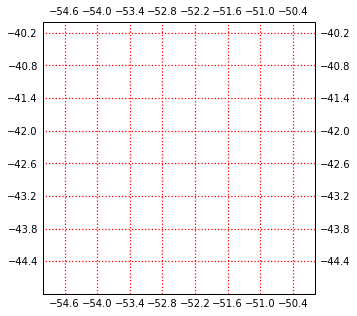

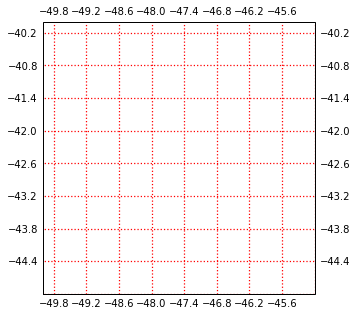

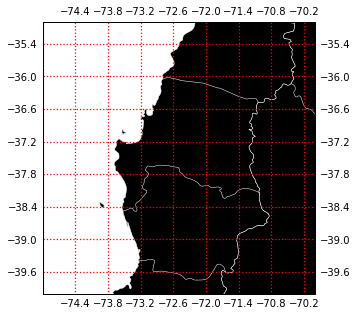

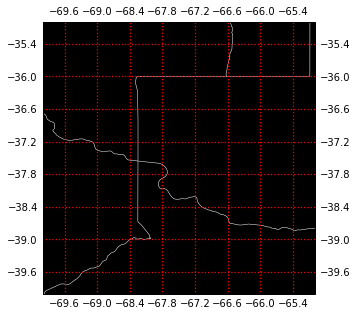

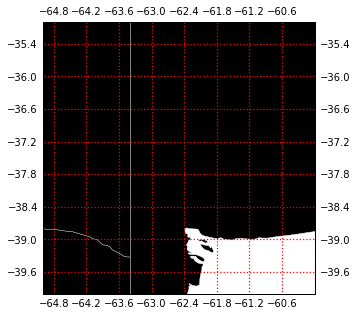

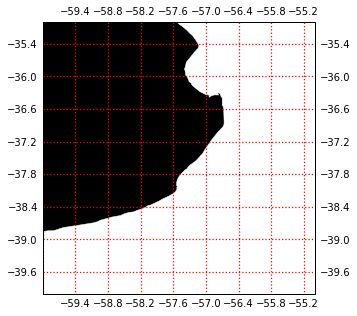

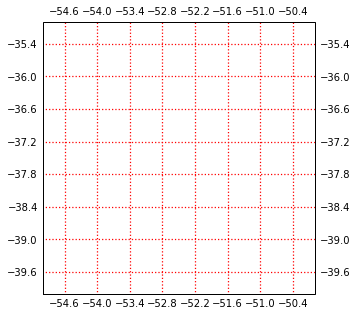

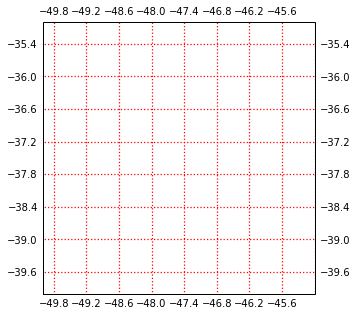

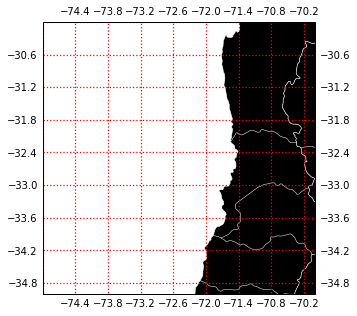

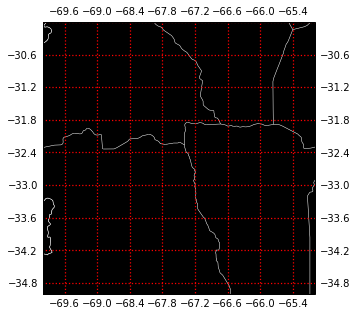

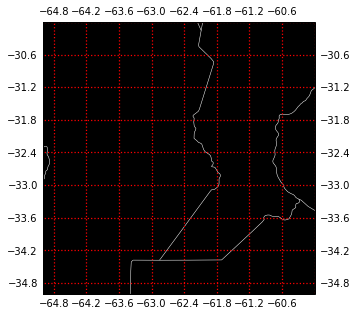

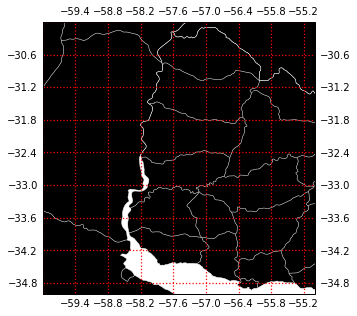

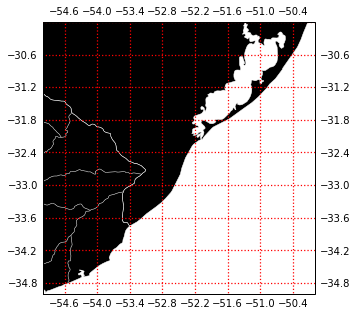

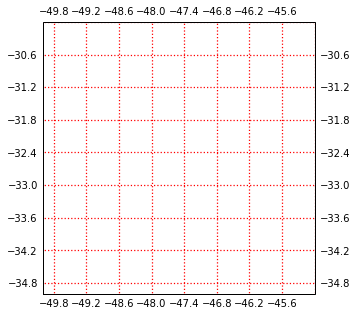

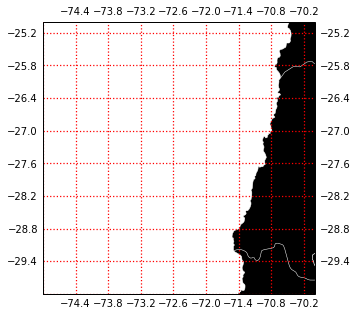

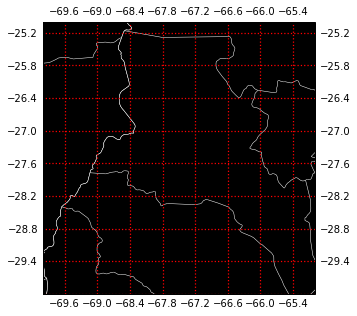

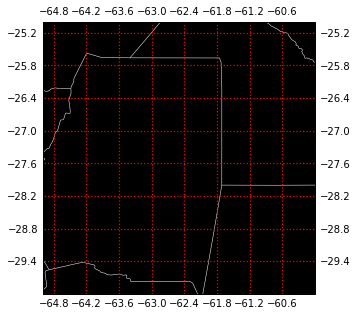

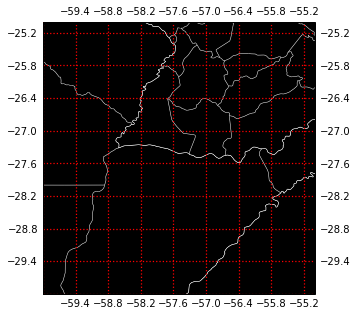

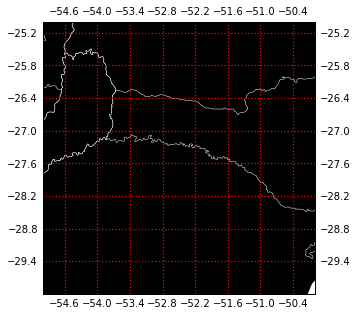

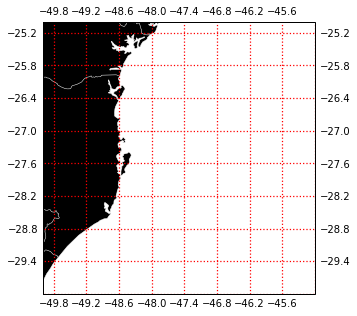

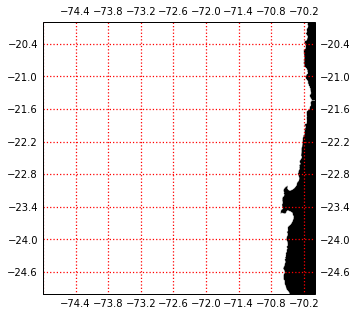

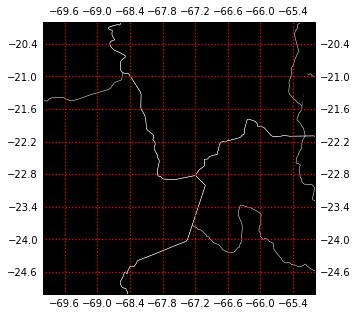

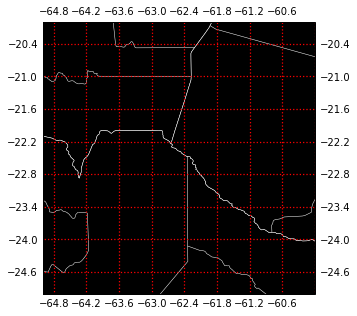

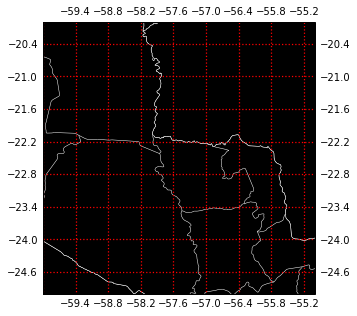

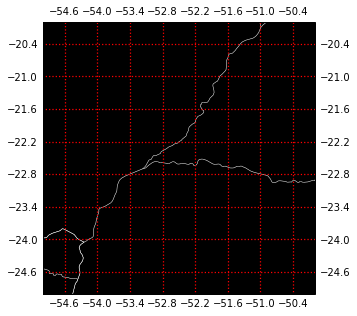

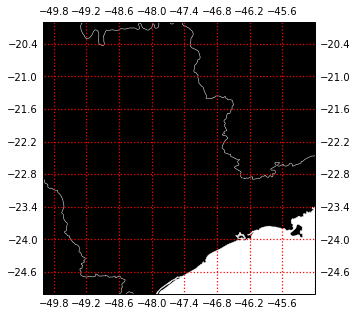

In [17]:
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from cima.goes.tiles import get_tile_extent


overlap = 1.5

@timeit
def generate(goes_store):
    bands = [
        ProductBand(Product.CMIPF, Band.CLEAN_LONGWAVE_WINDOW),
        ProductBand(Product.RadF, Band.RED),
    ]
    return generate_tiles(
        goes_store,
        bands,
        lat_south=-45,
        lat_north=-20,
        lon_west=-75,
        lon_east=-45,
        lat_step=5,
        lon_step=5,
        lon_overlap=overlap,
        lat_overlap=overlap,
    )


def get_ftp_info():
    return storage_info(
        storage_type.FTP, 
        host=FTP_HOST, 
        user=FTP_USER, 
        password=FTP_PASSWORD)


def tiles_generation():
    # Retrieve GCS credentials from FTP server
    ftp_info = get_ftp_info()
    credentials_as_dict = get_gcs_credentials(ftp_info)
    
    # Create GOES storage access
    goes_info = goesdata_info(storage_type.GCS, 
                               credentials_as_dict=credentials_as_dict)

    # Generate and save tiles data
    tiles = generate(goes_info)
    print('Generated: ', tiles)
    save_tiles(ftp_info, TILES_FILEPATH, tiles)
    

def add_cultural(ax):
    states_provinces = cartopy.feature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='10m',
        facecolor='black')

    countries = cartopy.feature.NaturalEarthFeature(
        category='cultural',
        name='admin_0_countries',
        scale='10m',
        facecolor='black')

    linewidth = 0.50
    ax.coastlines(resolution='10m', color='white', linewidth=linewidth)
    ax.add_feature(countries, edgecolor='white', linewidth=linewidth)
    ax.add_feature(states_provinces, edgecolor='white', linewidth=linewidth)


def add_grid(ax):
    linewidth = 1.25
    ax.gridlines(linewidth=linewidth,
                      linestyle='dotted',
                      color='r',
                      crs=ccrs.PlateCarree(),
                      draw_labels=True)

    
def show_tile(tile):
    fig = plt.figure(figsize=(5, 5))
    try:
        ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
        extent = get_tile_extent(tile, trim_excess=overlap)
        ax.set_extent(extent, crs=ccrs.PlateCarree())
        add_cultural(ax)
        ax.grid(color='r', linestyle='-', linewidth=2)
        add_grid(ax)
        fig.add_axes(ax, projection=ccrs.PlateCarree())
        plt.show()
    finally:
        fig.clear()
        plt.close()
    
    
def retrieve_tiles_information():
    # Retrieve the saved tiles data
    ftp_info = get_ftp_info()
    tiles = load_tiles(ftp_info, TILES_FILEPATH)
    for _, tile in tiles[(Product.RadF, Band.RED)].items():
        show_tile(tile)


#tiles_generation()
retrieve_tiles_information()
